In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_selection import mutual_info_classif
from yellowbrick.model_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, StratifiedKFold, StratifiedKFold
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, precision_score, recall_score, f1_score
from sklearn import model_selection
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import NearestCentroid
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier


# pip install -U imbalanced-learn
path = 'data/log2.csv'
data = pd.read_csv(path)
data.shape
data
# print(data[:50])

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


In [2]:
df = pd.DataFrame(data)


X=df.drop("Action",axis=1)
y=df['Action']


# Apply undersampling
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled_under, y_resampled_under = rus.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_resampled_under, y_resampled_under, test_size=0.25, random_state=42)


# Apply oversampling
ros = RandomOverSampler(sampling_strategy='minority')
X_resampled_over, y_resampled_over = ros.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_resampled_over, y_resampled_over, test_size=0.25, random_state=42)


# Apply smote_tomek
smote_tomek = SMOTETomek(sampling_strategy="auto")
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train_smote_tomek, X_test_smote_tomek, y_train_smote_tomek, y_test_smote_tomek = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)


In [22]:
def model1(model, sampling_name, features_train, features_test, labels_train, labels_test, train, labels, n_splits=10):
    clf = model
    clf.fit(features_train, labels_train.ravel())
    pred = clf.predict(features_test)

    # Confusion Matrix
    cnf_matrix = confusion_matrix(labels_test, pred)
    plt.figure(1, figsize=(6, 3))

    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) for each class
    tp = np.diag(cnf_matrix)
    fp = np.sum(cnf_matrix, axis=0) - tp
    fn = np.sum(cnf_matrix, axis=1) - tp
    tn = np.sum(cnf_matrix) - (tp + fp + fn)

    # Display the TP, FP, TN, FN for each class
    class_labels = ['allow', 'deny', 'drop', 'reset-both']
    for i, label in enumerate(class_labels):
        print(f"Class: {label}")
        print(f"TP: {tp[i]}, FP: {fp[i]}, TN: {tn[i]}, FN: {fn[i]}")

    # Display Confusion Matrix
    sns.heatmap(cnf_matrix, cmap="coolwarm_r", annot=True, linewidths=0.5, fmt='d', xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(sampling_name + " Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Display Classification Report
    print("============== Report ==================")
    print(classification_report(labels_test, pred))

    # Calculate Accuracy, Precision, Recall, and F1-Score
    accuracy = accuracy_score(labels_test, pred)
    precision = precision_score(labels_test, pred, average='macro')
    recall = recall_score(labels_test, pred, average='macro')
    f1 = f1_score(labels_test, pred, average='macro')
    mcc = matthews_corrcoef(labels_test, pred)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print('Mathews Corr Coef:',mcc)
    print("========================================")

    # K-fold Cross-validation
    skf = StratifiedKFold(n_splits=n_splits)
    cv_scores = cross_val_score(clf, train, labels.ravel(), cv=skf)
    print("Cross-validation scores:", cv_scores)
    print("Mean CV score:", np.mean(cv_scores))
    print("Standard deviation of CV scores:", np.std(cv_scores))
    print("\n========================================")

    return cnf_matrix, clf

/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Class: allow
TP: 13, FP: 5, TN: 6969, FN: 0
Class: deny
TP: 3763, FP: 2578, TN: 614, FN: 32
Class: drop
TP: 598, FP: 30, TN: 3792, FN: 2567
Class: reset-both
TP: 0, FP: 0, TN: 6973, FN: 14


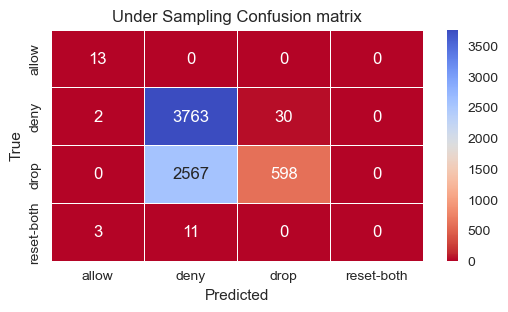

============== Report ==================
              precision    recall  f1-score   support

       allow       0.72      1.00      0.84        13
        deny       0.59      0.99      0.74      3795
        drop       0.95      0.19      0.32      3165
  reset-both       0.00      0.00      0.00        14

    accuracy                           0.63      6987
   macro avg       0.57      0.55      0.47      6987
weighted avg       0.76      0.63      0.55      6987

Accuracy: 0.6260197509660799
Precision: 0.5669727605414074
Recall: 0.545127350155168
F1-Score: 0.47413233526669474
Mathews Corr Coef: 0.31849883855377553


/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sparro

Cross-validation scores: [0.95132743 0.86817211 0.82664429 0.98687624 0.9839768  0.98275599
 0.97405768 0.97817793 0.78040592 0.98290859]
Mean CV score: 0.9315302991066343
Standard deviation of CV scores: 0.07301234832619094

Class: allow
TP: 13, FP: 1, TN: 6973, FN: 0
Class: deny
TP: 3782, FP: 20, TN: 3172, FN: 13
Class: drop
TP: 3154, FP: 11, TN: 3811, FN: 11
Class: reset-both
TP: 5, FP: 1, TN: 6972, FN: 9


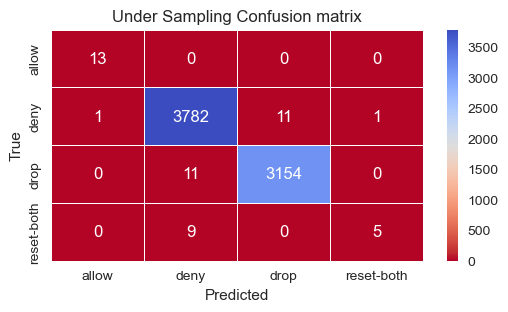

============== Report ==================
              precision    recall  f1-score   support

       allow       0.93      1.00      0.96        13
        deny       0.99      1.00      1.00      3795
        drop       1.00      1.00      1.00      3165
  reset-both       0.83      0.36      0.50        14

    accuracy                           1.00      6987
   macro avg       0.94      0.84      0.86      6987
weighted avg       1.00      1.00      0.99      6987

Accuracy: 0.9952769428939459
Precision: 0.938292214801959
Recall: 0.8375604459418595
F1-Score: 0.863785907401481
Mathews Corr Coef: 0.9905424498851105
Cross-validation scores: [0.99664327 0.95987183 0.94887838 0.99832138 0.96505417 0.99847398
 0.99847398 0.99801618 0.96627499 0.99740577]
Mean CV score: 0.9827413930244884
Standard deviation of CV scores: 0.019060667877908038

Class: allow
TP: 13, FP: 0, TN: 6974, FN: 0
Class: deny
TP: 3782, FP: 14, TN: 3178, FN: 13
Class: drop
TP: 3165, FP: 12, TN: 3810, FN: 0
Class: re

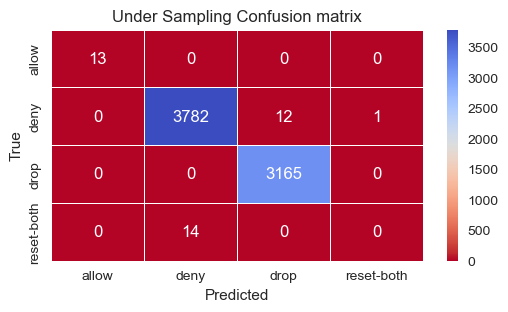

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00        13
        deny       1.00      1.00      1.00      3795
        drop       1.00      1.00      1.00      3165
  reset-both       0.00      0.00      0.00        14

    accuracy                           1.00      6987
   macro avg       0.75      0.75      0.75      6987
weighted avg       0.99      1.00      1.00      6987

Accuracy: 0.9961356805495921
Precision: 0.7481336897544356
Recall: 0.7491436100131752
F1-Score: 0.7486377521954682
Mathews Corr Coef: 0.9922626755550449
Cross-validation scores: [0.911657   0.99374428 0.91179612 0.91042271 0.98672364 0.98489242
 0.91377995 0.89195788 0.97268427 0.97665192]
Mean CV score: 0.9454310178348594
Standard deviation of CV scores: 0.03830492917097619

Class: allow
TP: 13, FP: 2, TN: 6972, FN: 0
Class: deny
TP: 3089, FP: 1, TN: 3191, FN: 706
Class: drop
TP: 3165, FP: 42, TN: 3780, FN: 0
Class: r

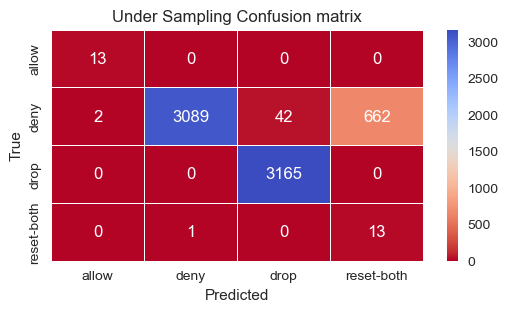

============== Report ==================
              precision    recall  f1-score   support

       allow       0.87      1.00      0.93        13
        deny       1.00      0.81      0.90      3795
        drop       0.99      1.00      0.99      3165
  reset-both       0.02      0.93      0.04        14

    accuracy                           0.90      6987
   macro avg       0.72      0.94      0.71      6987
weighted avg       0.99      0.90      0.94      6987

Accuracy: 0.8988120795763561
Precision: 0.7181264873999669
Recall: 0.9356342932429889
F1-Score: 0.7142572349505011
Mathews Corr Coef: 0.8335598530830297
Cross-validation scores: [0.95102228 0.98108026 0.95193041 0.95620327 0.93850145 0.96505417
 0.96062872 0.95330383 0.9592553  0.96215474]
Mean CV score: 0.9579134426593499
Standard deviation of CV scores: 0.010483972108972372

Class: allow
TP: 13, FP: 0, TN: 6974, FN: 0
Class: deny
TP: 0, FP: 0, TN: 3192, FN: 3795
Class: drop
TP: 3165, FP: 15, TN: 3807, FN: 0
Class: re

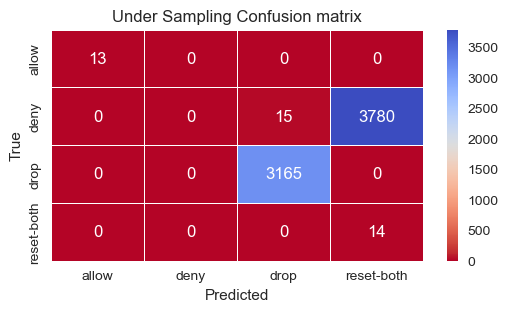

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00        13
        deny       0.00      0.00      0.00      3795
        drop       1.00      1.00      1.00      3165
  reset-both       0.00      1.00      0.01        14

    accuracy                           0.46      6987
   macro avg       0.50      0.75      0.50      6987
weighted avg       0.45      0.46      0.45      6987

Accuracy: 0.45684843280377846
Precision: 0.49974326394207336
Recall: 0.75
F1-Score: 0.5012472187456543
Mathews Corr Coef: 0.5002918969776605


/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sparro

Cross-validation scores: [0.88495575 0.80866646 0.91194873 0.83915764 0.8036014  0.77521746
 0.79948115 0.89439951 0.86387914 0.90904929]
Mean CV score: 0.8490356535599657
Standard deviation of CV scores: 0.047774936642798076

Class: allow
TP: 2, FP: 3, TN: 6971, FN: 11
Class: deny
TP: 1966, FP: 4, TN: 3188, FN: 1829
Class: drop
TP: 3165, FP: 665, TN: 3157, FN: 0
Class: reset-both
TP: 10, FP: 1172, TN: 5801, FN: 4


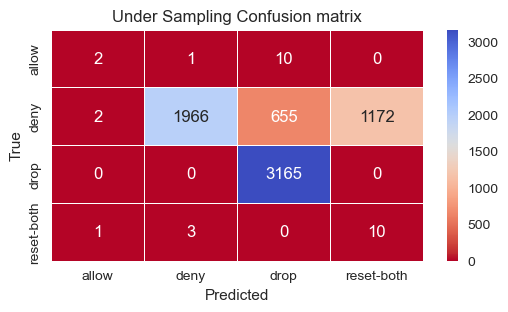

============== Report ==================
              precision    recall  f1-score   support

       allow       0.40      0.15      0.22        13
        deny       1.00      0.52      0.68      3795
        drop       0.83      1.00      0.90      3165
  reset-both       0.01      0.71      0.02        14

    accuracy                           0.74      6987
   macro avg       0.56      0.60      0.46      6987
weighted avg       0.92      0.74      0.78      6987

Accuracy: 0.7360812938314012
Precision: 0.5582001343034994
Recall: 0.5965454835020053
F1-Score: 0.4564808897368185
Mathews Corr Coef: 0.6148799338099392
Cross-validation scores: [0.35016784 0.28516936 0.34320159 0.35037387 0.34640623 0.35495193
 0.36242942 0.35724096 0.34808485 0.37372196]
Mean CV score: 0.347174800286912
Standard deviation of CV scores: 0.022316671853394757



In [23]:
classifiers = [
    ('Support Vector Machine (SVM)', svm.LinearSVC(C=1, loss='hinge', max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Balanced Random Forest', BalancedRandomForestClassifier()),
    ('Easy Ensemble', EasyEnsembleClassifier()),
    ('Nearest Centroid', NearestCentroid())
]

sampling_name = "Under Sampling"
for classifier in classifiers:
    cnf_matrix, clf = model1(classifier[1], sampling_name, X_train_under, X_test_under, y_train_under, y_test_under, X, y)


/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Class: allow
TP: 4841, FP: 528, TN: 15895, FN: 4516
Class: deny
TP: 123, FP: 263, TN: 21733, FN: 3661
Class: drop
TP: 3258, FP: 483, TN: 22039, FN: 0
Class: reset-both
TP: 8594, FP: 7690, TN: 8709, FN: 787


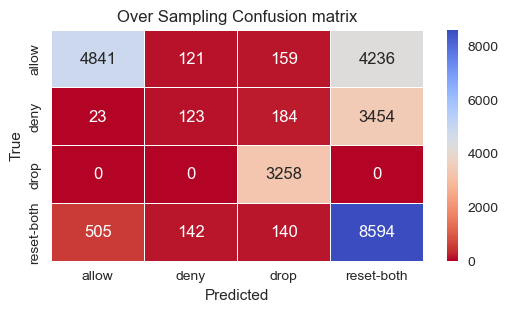

============== Report ==================
              precision    recall  f1-score   support

       allow       0.90      0.52      0.66      9357
        deny       0.32      0.03      0.06      3784
        drop       0.87      1.00      0.93      3258
  reset-both       0.53      0.92      0.67      9381

    accuracy                           0.65     25780
   macro avg       0.65      0.62      0.58     25780
weighted avg       0.68      0.65      0.61     25780

Accuracy: 0.652288595810706
Precision: 0.6547394895561078
Recall: 0.616494746900888
F1-Score: 0.5792913360767964
Mathews Corr Coef: 0.533179319381379


/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_

Cross-validation scores: [0.96551724 0.87015563 0.98626583 0.98428201 0.97878834 0.97894094
 0.97649931 0.98229818 0.98260339 0.98214558]
Mean CV score: 0.9687496463776661
Standard deviation of CV scores: 0.03331506400442928

Class: allow
TP: 9355, FP: 0, TN: 16423, FN: 2
Class: deny
TP: 3773, FP: 10, TN: 21986, FN: 11
Class: drop
TP: 3250, FP: 9, TN: 22513, FN: 8
Class: reset-both
TP: 9381, FP: 2, TN: 16397, FN: 0


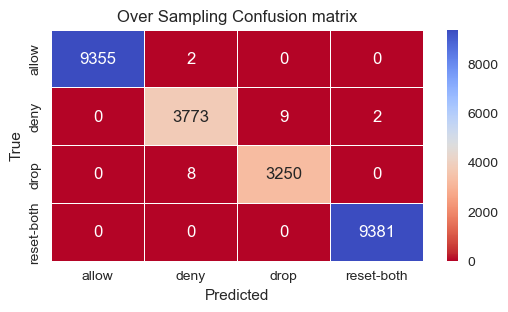

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9357
        deny       1.00      1.00      1.00      3784
        drop       1.00      1.00      1.00      3258
  reset-both       1.00      1.00      1.00      9381

    accuracy                           1.00     25780
   macro avg       1.00      1.00      1.00     25780
weighted avg       1.00      1.00      1.00     25780

Accuracy: 0.9991854150504267
Precision: 0.998595465135719
Recall: 0.9986059463415836
F1-Score: 0.998600689818102
Mathews Corr Coef: 0.9988335427991494
Cross-validation scores: [0.99664327 0.95987183 0.94887838 0.99832138 0.96520678 0.99847398
 0.99832138 0.99786357 0.96627499 0.99740577]
Mean CV score: 0.9827261328383139
Standard deviation of CV scores: 0.019021820003455054

Class: allow
TP: 9323, FP: 2, TN: 16421, FN: 34
Class: deny
TP: 1449, FP: 1023, TN: 20973, FN: 2335
Class: drop
TP: 3258, FP: 9, TN: 22513, FN: 0


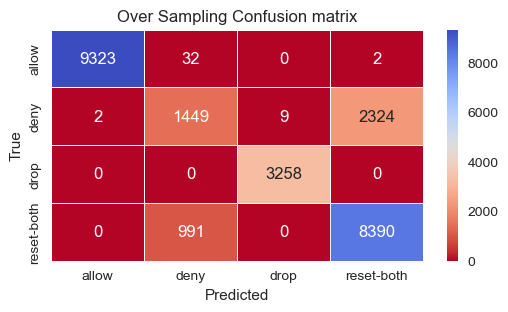

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9357
        deny       0.59      0.38      0.46      3784
        drop       1.00      1.00      1.00      3258
  reset-both       0.78      0.89      0.83      9381

    accuracy                           0.87     25780
   macro avg       0.84      0.82      0.82     25780
weighted avg       0.86      0.87      0.86     25780

Accuracy: 0.86966640806827
Precision: 0.8415342866096384
Recall: 0.8184138543654369
F1-Score: 0.8237198713376499
Mathews Corr Coef: 0.8136681928816552
Cross-validation scores: [0.911657   0.99374428 0.91179612 0.91042271 0.98672364 0.98489242
 0.91377995 0.89195788 0.97268427 0.97665192]
Mean CV score: 0.9454310178348594
Standard deviation of CV scores: 0.03830492917097619

Class: allow
TP: 9355, FP: 0, TN: 16423, FN: 2
Class: deny
TP: 3771, FP: 6, TN: 21990, FN: 13
Class: drop
TP: 3254, FP: 9, TN: 22513, FN: 4
Class: 

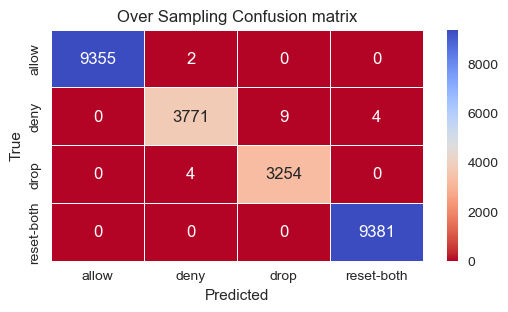

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9357
        deny       1.00      1.00      1.00      3784
        drop       1.00      1.00      1.00      3258
  reset-both       1.00      1.00      1.00      9381

    accuracy                           1.00     25780
   macro avg       1.00      1.00      1.00     25780
weighted avg       1.00      1.00      1.00     25780

Accuracy: 0.9992629945694337
Precision: 0.998806756907779
Recall: 0.9987807478060549
F1-Score: 0.9987933777206752
Mathews Corr Coef: 0.9989447048905862
Cross-validation scores: [0.94705523 0.97894416 0.95193041 0.95482985 0.94079048 0.96154433
 0.95956051 0.9511674  0.96230734 0.96108653]
Mean CV score: 0.9569216236931224
Standard deviation of CV scores: 0.009897654683742037

Class: allow
TP: 9334, FP: 1, TN: 16422, FN: 23
Class: deny
TP: 3011, FP: 2301, TN: 19695, FN: 773
Class: drop
TP: 3258, FP: 9, TN: 22513, FN: 0


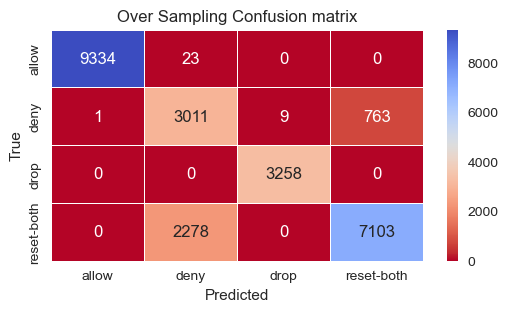

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9357
        deny       0.57      0.80      0.66      3784
        drop       1.00      1.00      1.00      3258
  reset-both       0.90      0.76      0.82      9381

    accuracy                           0.88     25780
   macro avg       0.87      0.89      0.87     25780
weighted avg       0.90      0.88      0.89     25780

Accuracy: 0.8807602792862684
Precision: 0.8667420322178497
Recall: 0.8876073771523181
F1-Score: 0.8707663627026392
Mathews Corr Coef: 0.8365314867164032
Cross-validation scores: [0.85962771 0.83277388 0.78818862 0.88631161 0.91072791 0.7706394
 0.99053868 0.90767587 0.92095224 0.94689455]
Mean CV score: 0.8814330474349639
Standard deviation of CV scores: 0.06567696224413909

Class: allow
TP: 445, FP: 0, TN: 16423, FN: 8912
Class: deny
TP: 2042, FP: 3453, TN: 18543, FN: 1742
Class: drop
TP: 3258, FP: 8542, TN: 13980, FN

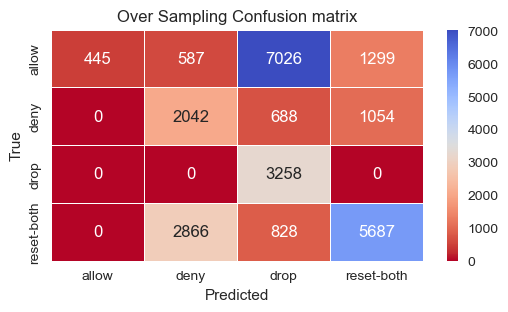

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      0.05      0.09      9357
        deny       0.37      0.54      0.44      3784
        drop       0.28      1.00      0.43      3258
  reset-both       0.71      0.61      0.65      9381

    accuracy                           0.44     25780
   macro avg       0.59      0.55      0.40     25780
weighted avg       0.71      0.44      0.39     25780

Accuracy: 0.44344453064391
Precision: 0.5887626396057528
Recall: 0.5483559797651183
F1-Score: 0.40413710280124115
Mathews Corr Coef: 0.3488250753869396
Cross-validation scores: [0.35016784 0.28516936 0.34320159 0.35037387 0.34640623 0.35495193
 0.36242942 0.35724096 0.34808485 0.37372196]
Mean CV score: 0.347174800286912
Standard deviation of CV scores: 0.022316671853394757



In [26]:
classifiers = [
    ('Support Vector Machine (SVM)', svm.LinearSVC(C=1, loss='hinge', max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Balanced Random Forest', BalancedRandomForestClassifier()),
    ('Easy Ensemble', EasyEnsembleClassifier()),
    ('Nearest Centroid', NearestCentroid())
]

sampling_name = "Over Sampling"
for classifier in classifiers:
    cnf_matrix, clf = model1(classifier[1], sampling_name,X_train_over, X_test_over, y_train_over, y_test_over, X, y)


/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Class: allow
TP: 6107, FP: 357, TN: 27936, FN: 3203
Class: deny
TP: 356, FP: 121, TN: 28070, FN: 9056
Class: drop
TP: 0, FP: 0, TN: 28138, FN: 9465
Class: reset-both
TP: 9015, FP: 21647, TN: 6540, FN: 401


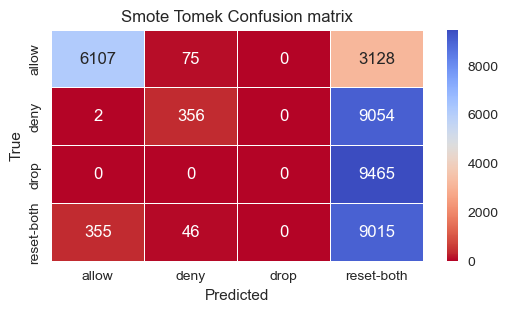

============== Report ==================


/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       allow       0.94      0.66      0.77      9310
        deny       0.75      0.04      0.07      9412
        drop       0.00      0.00      0.00      9465
  reset-both       0.29      0.96      0.45      9416

    accuracy                           0.41     37603
   macro avg       0.50      0.41      0.32     37603
weighted avg       0.49      0.41      0.32     37603



/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.41161609446054837
Precision: 0.4962786021955586
Recall: 0.4127995751221092
F1-Score: 0.324046024602712
Mathews Corr Coef: 0.33786667945901644


/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sparrow/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_

Cross-validation scores: [0.97741837 0.9914556  0.80146498 0.98489242 0.79414009 0.98290859
 0.94933618 0.98199298 0.78452617 0.98122997]
Mean CV score: 0.9229365348089411
Standard deviation of CV scores: 0.08554667364474185

Class: allow
TP: 9307, FP: 2, TN: 28291, FN: 3
Class: deny
TP: 9342, FP: 36, TN: 28155, FN: 70
Class: drop
TP: 9455, FP: 9, TN: 28129, FN: 10
Class: reset-both
TP: 9392, FP: 60, TN: 28127, FN: 24


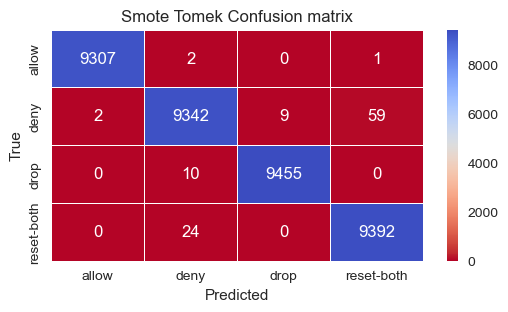

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9310
        deny       1.00      0.99      0.99      9412
        drop       1.00      1.00      1.00      9465
  reset-both       0.99      1.00      1.00      9416

    accuracy                           1.00     37603
   macro avg       1.00      1.00      1.00     37603
weighted avg       1.00      1.00      1.00     37603

Accuracy: 0.9971544823551313
Precision: 0.9971618868919565
Recall: 0.9971587686809916
F1-Score: 0.9971586063750233
Mathews Corr Coef: 0.9962070829050131
Cross-validation scores: [0.99664327 0.95987183 0.94887838 0.99832138 0.96520678 0.99847398
 0.99847398 0.99786357 0.96627499 0.99725317]
Mean CV score: 0.9827261328383139
Standard deviation of CV scores: 0.019022676954186368

Class: allow
TP: 9210, FP: 0, TN: 28293, FN: 100
Class: deny
TP: 18, FP: 2264, TN: 25927, FN: 9394
Class: drop
TP: 9465, FP: 475, TN: 27663, FN:

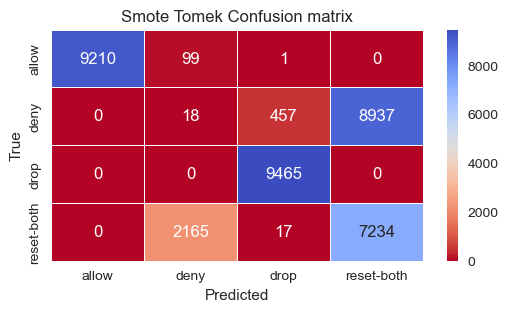

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      0.99      0.99      9310
        deny       0.01      0.00      0.00      9412
        drop       0.95      1.00      0.98      9465
  reset-both       0.45      0.77      0.57      9416

    accuracy                           0.69     37603
   macro avg       0.60      0.69      0.63     37603
weighted avg       0.60      0.69      0.63     37603

Accuracy: 0.689492859612265
Precision: 0.6018612770663795
Recall: 0.6898595233942577
F1-Score: 0.6346610239303273
Mathews Corr Coef: 0.6146591089882603
Cross-validation scores: [0.911657   0.99374428 0.91179612 0.91042271 0.98672364 0.98489242
 0.91377995 0.89195788 0.97268427 0.97665192]
Mean CV score: 0.9454310178348594
Standard deviation of CV scores: 0.03830492917097619

Class: allow
TP: 9307, FP: 2, TN: 28291, FN: 3
Class: deny
TP: 9342, FP: 36, TN: 28155, FN: 70
Class: drop
TP: 9455, FP: 10, TN: 28128, FN: 10
Cla

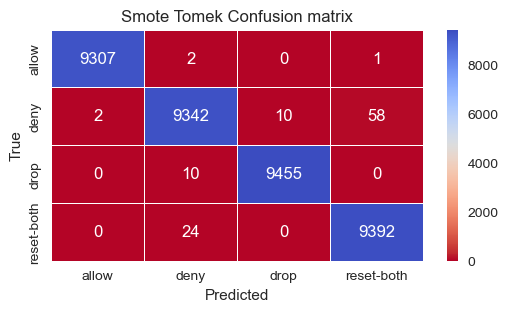

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9310
        deny       1.00      0.99      0.99      9412
        drop       1.00      1.00      1.00      9465
  reset-both       0.99      1.00      1.00      9416

    accuracy                           1.00     37603
   macro avg       1.00      1.00      1.00     37603
weighted avg       1.00      1.00      1.00     37603

Accuracy: 0.9971544823551313
Precision: 0.9971617832213463
Recall: 0.9971587686809916
F1-Score: 0.9971586047382878
Mathews Corr Coef: 0.9962070489114832
Cross-validation scores: [0.94858102 0.98016478 0.95406684 0.96184953 0.93758584 0.9589501
 0.9591027  0.95391424 0.96047612 0.95040439]
Mean CV score: 0.956509556755622
Standard deviation of CV scores: 0.010428057335902349

Class: allow
TP: 9210, FP: 0, TN: 28293, FN: 100
Class: deny
TP: 18, FP: 2264, TN: 25927, FN: 9394
Class: drop
TP: 9465, FP: 475, TN: 27663, FN: 0

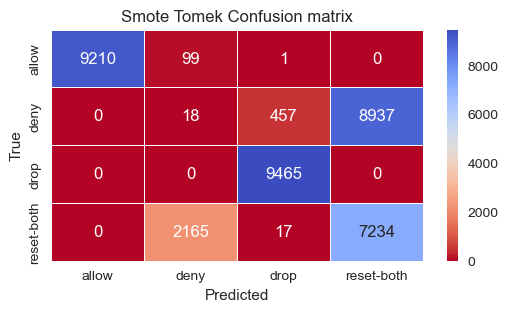

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      0.99      0.99      9310
        deny       0.01      0.00      0.00      9412
        drop       0.95      1.00      0.98      9465
  reset-both       0.45      0.77      0.57      9416

    accuracy                           0.69     37603
   macro avg       0.60      0.69      0.63     37603
weighted avg       0.60      0.69      0.63     37603

Accuracy: 0.689492859612265
Precision: 0.6018612770663795
Recall: 0.6898595233942577
F1-Score: 0.6346610239303273
Mathews Corr Coef: 0.6146591089882603
Cross-validation scores: [0.9017394  0.82133049 0.89775675 0.88158096 0.79307188 0.77109721
 0.8199298  0.88707462 0.94323211 0.90889669]
Mean CV score: 0.8625709893196858
Standard deviation of CV scores: 0.0539471266789353

Class: allow
TP: 401, FP: 0, TN: 28293, FN: 8909
Class: deny
TP: 4977, FP: 3033, TN: 25158, FN: 4435
Class: drop
TP: 9465, FP: 9505, TN: 18633, FN:

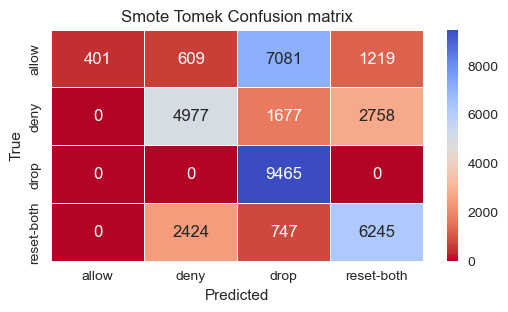

============== Report ==================
              precision    recall  f1-score   support

       allow       1.00      0.04      0.08      9310
        deny       0.62      0.53      0.57      9412
        drop       0.50      1.00      0.67      9465
  reset-both       0.61      0.66      0.64      9416

    accuracy                           0.56     37603
   macro avg       0.68      0.56      0.49     37603
weighted avg       0.68      0.56      0.49     37603

Accuracy: 0.560806318644789
Precision: 0.6828078031590814
Recall: 0.5587744477611858
F1-Score: 0.4889184999244978
Mathews Corr Coef: 0.4520865895990437
Cross-validation scores: [0.35016784 0.28516936 0.34320159 0.35037387 0.34640623 0.35495193
 0.36242942 0.35724096 0.34808485 0.37372196]
Mean CV score: 0.347174800286912
Standard deviation of CV scores: 0.022316671853394757



In [29]:
classifiers = [
    ('Support Vector Machine (SVM)', svm.LinearSVC(C=1, loss='hinge', max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Balanced Random Forest', BalancedRandomForestClassifier()),
    ('Easy Ensemble', EasyEnsembleClassifier()),
    ('Nearest Centroid', NearestCentroid())
]

sampling_name = "Smote Tomek"
for classifier in classifiers:
    cnf_matrix, clf = model1(classifier[1], sampling_name, X_train_smote_tomek, X_test_smote_tomek, y_train_smote_tomek, y_test_smote_tomek, X, y)
